In [ ]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 94.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 91.9 MB/s eta 0:00:00
  ERROR: HTTP error 403 while getting https://download.pytorch.org/whl/nightly/nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (from https://download.pytorch.org/whl/nightly/cu113/nvidia-cuda-nvrtc-cu12/)
ERROR: Could not install requirement nvidia-cuda-nvrtc-cu12==12.1.105 from https://download.pytorch.org/whl/nightly/nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (from torch) because of HTTP error 403 Client Error: Forbidden for url: https://download.pytorch.org/whl/nightly/nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl for URL https

In [ ]:
import torch
import torchvision
from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.


'\n# Try to import the going_modular directory, download it from GitHub if it doesn\'t work\ntry:\n    from going_modular.going_modular import data_setup, engine\n    from helper_functions import download_data, set_seeds, plot_loss_curves\nexcept:\n    # Get the going_modular scripts\n    print("[INFO] Couldn\'t find going_modular or helper_functions scripts... downloading them from GitHub.")\n    !git clone https://github.com/mrdbourke/pytorch-deep-learning\n    !mv pytorch-deep-learning/going_modular .\n    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script\n    !rm -rf pytorch-deep-learning\n    from going_modular.going_modular import data_setup, engine\n    from helper_functions import download_data, set_seeds, plot_loss_curves\n'

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

dataset

In [ ]:
import pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from google.colab import drive
import shutil
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Resize, Normalize


In [ ]:
drive.mount('/content/drive')

drive_path = '/content/drive/My Drive/logos_dataset'
colab_data_path = '/content/logos_dataset'
images_path = os.path.join(drive_path, 'Logos')
csv_path = os.path.join(drive_path, 'LogoDatabase.csv')
train_path = os.path.join(colab_data_path, 'train')
test_path = os.path.join(colab_data_path, 'test')

Mounted at /content/drive


In [ ]:
def filter_and_copy_images(images_path, csv_path, train_path, test_path, test_size=0.2, random_state=42):
    # Get all image files
    png_files = [f for f in os.listdir(images_path) if f.lower().endswith('.png')]
    jpg_files = [f for f in os.listdir(images_path) if f.lower().endswith('.jpg') or f.lower().endswith('.jpeg')]
    image_files = png_files + jpg_files

    # Load DataFrame
    df = pd.read_csv(csv_path)

    # Filter DataFrame to include only images present in the directory
    df = df[df['fileName'].isin(image_files)]

    # Split into train and test DataFrames
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)

    # Function to copy images
    def copy_images(image_list, source_folder, destination_folder):
        for _, row in image_list.iterrows():
            image_name = row['fileName']
            src = os.path.join(source_folder, image_name)
            dst = os.path.join(destination_folder, image_name)
            shutil.copy(src, dst)

    # Create directories if they don't exist
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)

    # Copy images to train and test directories
    copy_images(train_df, images_path, train_path)
    copy_images(test_df, images_path, test_path)

    # Remove entries from df if file doesn't exist in train or test directory
    df = df[df['fileName'].isin(train_df['fileName']) | df['fileName'].isin(test_df['fileName'])]

    # Copy LogoDatabase.csv to colab_data_path
    colab_data_path = '/content/logos_dataset'  # Adjust this path as per your setup
    shutil.copy(csv_path, colab_data_path)

    return df, train_df, test_df


training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch.utils.data import DataLoader
from torch.optim import Adam

In [ ]:
# Function to clip gradients
def clip_gradients(parameters, clip_value=1.0):
    torch.nn.utils.clip_grad_norm_(parameters, clip_value)

# Function to get learning rate scheduler
def get_scheduler(optimizer, num_warmup_steps, num_training_steps):
    return torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, end_factor=1.0, total_iters=num_warmup_steps)

In [ ]:

class LogoDataset(Dataset):
    def __init__(self, annotations_file, train_dir, test_dir, transform=None):
        self.data = pd.read_csv(annotations_file)
        self.train_dir = train_dir
        self.test_dir = test_dir
        self.transform = transform
        self._filter_data()

    def _filter_data(self):
        self.data = self.data[self.data['fileName'].apply(lambda x: self._file_in_dirs(x))]

    def _file_in_dirs(self, filename):
        train_file_path = os.path.join(self.train_dir, filename)
        test_file_path = os.path.join(self.test_dir, filename)
        return os.path.exists(train_file_path) or os.path.exists(test_file_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 1]  # assuming second column is fileName
        if os.path.exists(os.path.join(self.train_dir, img_name)):
            img_path = os.path.join(self.train_dir, img_name)
        elif os.path.exists(os.path.join(self.test_dir, img_name)):
            img_path = os.path.join(self.test_dir, img_name)
        else:
            raise FileNotFoundError(f"Image {img_name} not found in train or test directories.")

        image = Image.open(img_path).convert("RGB")
        label = self.data.iloc[idx, 0]  # assuming first column is label
        if self.transform:
            image = self.transform(image)
        return image, label


In [ ]:
df, train_df, test_df = filter_and_copy_images(images_path=images_path,
                                               csv_path=csv_path,
                                               train_path=train_path,
                                               test_path=test_path,
                                               test_size=0.2,
                                               random_state=42)

In [ ]:
train_df

,logoName,fileName
1465,Eni,eni-logo.png
358,Arsenal,arsenal-fc-logo.png
1112,Target Stores,target-stores-vector-logo-400x400.png
932,Dodge Group,dodge-group-vector-logo-400x400.png
693,SG Dynamo Dresden,sg-dynamo-dresden-vector-logo-400x400.png
...,...,...
1118,Nike Ball,nike-ball-vector-logo-400x400.png
1158,Kerastase,kerastase-vector-logo-400x400.png
1329,Knauf,knauf-vector-logo-400x400.png
874,OTE TV,ote-tv-vector-logo-400x400.png


In [ ]:
test_df

,logoName,fileName
418,Freddie Mercury tribute,freddie-mercury-tribute-logo-vector-400x400.png
319,My fish,my-fish-vector-logo-400x400.png
1055,Urban Outfitters,urban-outfitters-logo-vector-download-400x400.png
65,Chennai Super Kings,chennai-super-kings-vector-logo-400x400.png
1045,China Airlines,china-airlines-logo-vector-download-400x400.jpg
...,...,...
1132,Popeye,popeye-vector-400x400.png
86,PlayStation 4 (PS4),playstation-4-logo-01.png
1407,Google Plus,google-plus-logo.png
267,Taco Bell new,taco-bell-logo-preview-400x400.png


In [ ]:
from torchvision import transforms

# Define transforms for training and testing
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 (example)
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Example normalization
])


In [ ]:
train_dataset = LogoDataset(
    annotations_file=os.path.join(colab_data_path, 'LogoDatabase.csv'),
    train_dir=train_path,
    test_dir=test_path,
    transform=data_transforms
)

test_dataset = LogoDataset(
    annotations_file=os.path.join(colab_data_path, 'LogoDatabase.csv'),
    train_dir=train_path,
    test_dir=test_path,
    transform=data_transforms)


In [ ]:
batch_size=32
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
model_name = "google/vit-base-patch16-224-in21k"  # You can choose a different ViT model if needed
model = ViTForImageClassification.from_pretrained(model_name, num_labels=len(df['logoName'].unique()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm.auto import tqdm

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
epochs = 10
model.train()  # Set model to training mode

for epoch in range(epochs):
    epoch_loss = 0.0

    for images, labels in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{epochs}'):
        images = images.to(device)
        label_to_index = {label: idx for idx, label in enumerate(set(labels))}
        label_indices = [label_to_index[label] for label in labels]
        labels = torch.tensor(label_indices)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Extract logits or relevant output
        logits = outputs.logits  # Adjust this based on what your model returns

        # Compute loss
        loss = loss_fn(logits, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_dataloader)
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}')


Epoch 1/10:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1/10, Loss: 6.3667


Epoch 2/10:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2/10, Loss: 5.0324


Epoch 3/10:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3/10, Loss: 4.0814


Epoch 4/10:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 4/10, Loss: 3.7105


Epoch 5/10:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 5/10, Loss: 3.5936


Epoch 6/10:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 6/10, Loss: 3.5466


Epoch 7/10:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 7/10, Loss: 3.5218


Epoch 8/10:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 8/10, Loss: 3.5072


Epoch 9/10:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 9/10, Loss: 3.4973


Epoch 10/10:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 10/10, Loss: 3.4923


In [ ]:
torch.save(model.state_dict(), "vit_logo_classification.pth")

inference

In [ ]:
model.load_state_dict(torch.load("vit_logo_classification.pth"))
model.to(device)
model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
from IPython.display import display
def preprocess_image(image_path, feature_extractor):
    image = Image.open(image_path)
    display(image)
    if image.mode != 'RGB':
        image = image.convert('RGB')
    inputs = feature_extractor(images=image, return_tensors="pt")
    image.show()
    return inputs

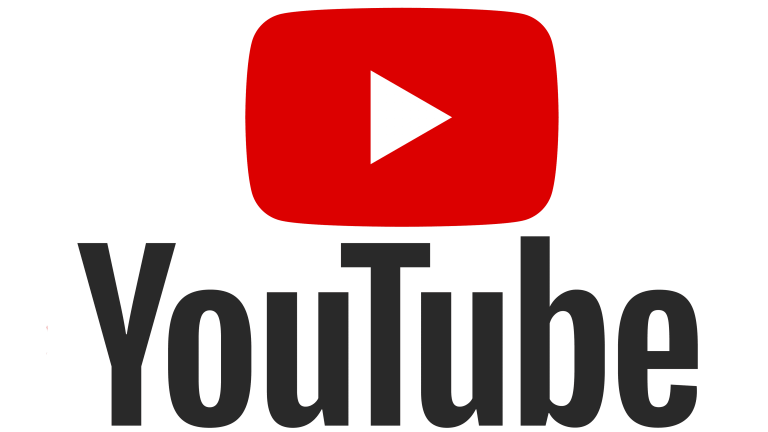

In [ ]:
image_path = "/content/YouTube_inference.png"  # Path to your image
inputs = preprocess_image(image_path, feature_extractor)
inputs = {k: v.to(device) for k, v in inputs.items()}

In [ ]:
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

predicted_class_idx = logits.argmax(-1).item()
predicted_class = df['logoName'].unique()[predicted_class_idx]
predicted_class

'YouTube'